In [1]:
#from interruptingcow import timeout

import matplotlib.pyplot as plt
from tqdm import tqdm

import os, sys, argparse, json, copy, logging

import torch
import torch.multiprocessing as mp


os.environ['ALFRED_ROOT'] = os.getcwd()
sys.path.append(os.path.join(os.environ['ALFRED_ROOT']))

from data.dataset import AlfredDataset
from models.config.configs import Config
from models.model.mmt import MultiModalTransformer
from models.nn.mrcnn import MaskRCNNDetector
from models.eval.eval_task import EvalTaskMMT
from models.eval.eval_subgoals import EvalSubgoalsMMT

from models.utils.vocab import Vocab

vocab = Vocab()
vocab.load("data/full_2.1.0_pp/vocab")

Vocab file loaded. Size: 1500


In [2]:
os.listdir("data/full_2.1.0_pp")

['valid_unseen_det_res_sep.pkl',
 'dec_in_vocab.w2id.json',
 'language_tests_seen.json',
 'valid_seen_high_action_instances.pkl',
 'debug_valid_seen_det_res_sep.json',
 'train_low_action_instances_mani.pkl',
 'debug_valid_unseen_det_res_all.json',
 'vocab.freq.json',
 'debug_train_low_action_seed_navi.json',
 'valid_seen_low_action_instances.pkl',
 'dec_out_vocab_high.w2id.json',
 'train',
 'valid_unseen_det_res_all.json',
 'train_det_res_sep.json',
 'dec_out_vocab_low.w2id.json',
 'valid_unseen_low_action_instances_mani.pkl',
 'dec_out_vocab_arg.w2id.json',
 'valid_seen_low_action_instances_mani.pkl',
 'vocab.w2id.json',
 'valid_unseen_high_action_instances.json',
 'failures_valid_seen_pred_all_mask.json',
 'results_valid_seen_pred_all_mask.json',
 'debug_valid_seen_low_action_instances_navi.json',
 'train_low_action_instances_navi.pkl',
 'valid_seen',
 'img_map_valid_unseen.json',
 'debug_valid_unseen_high_action_instances.json',
 'valid_unseen_low_action_instances_mani.json',
 'debu

In [3]:
import revtok
from hitut_train.custom_eval import get_goal_conditions_meet, remove_spaces_and_lower, setup_scene, load_all_trial_paths

In [4]:
core_mask_op = "taskset -pc %s %d" %('0-40', os.getpid())
os.system(core_mask_op)

# multiprocessing settings
mp.set_start_method('spawn')
manager = mp.Manager()

# parser
parser = argparse.ArgumentParser()
Config(parser)

# eval settings
parser.add_argument('--reward_config', default='models/config/rewards.json')
parser.add_argument('--eval_split', type=str, default='valid_seen', choices=['valid_seen', 'valid_unseen'])
parser.add_argument('--eval_path', type=str, default="exp/something")
parser.add_argument('--ckpt_name', type=str, default="model_best_seen.pth")
parser.add_argument('--num_core_per_proc', type=int, default=5, help='cpu cores used per process')
# parser.add_argument('--model', type=str, default='models.model.seq2seq_im_mask')
parser.add_argument('--subgoals', type=str, help="subgoals to evaluate independently, eg:all or GotoLocation,PickupObject...", default="")
parser.add_argument('--smooth_nav', dest='smooth_nav', action='store_true', help='smooth nav actions (might be required based on training data)')
parser.add_argument('--max_high_steps', type=int, default=20, help='max steps before a high-level episode termination')
parser.add_argument('--max_high_fails', type=int, default=5, help='max failing times to try high-level proposals')
parser.add_argument('--max_fails', type=int, default=999, help='max failing times in ALFRED benchmark')
parser.add_argument('--max_low_steps', type=int, default=50, help='max steps before a low-level episode termination')
parser.add_argument('--only_eval_mask', dest='only_eval_mask', action='store_true')
parser.add_argument('--use_gt_navigation', dest='use_gt_navigation', action='store_true')
parser.add_argument('--use_gt_high_action', dest='use_gt_high_action', action='store_true')
parser.add_argument('--use_gt_mask', dest='use_gt_mask', action='store_true')
parser.add_argument('--save_video', action='store_true')

parser.add_argument('--eval_disable_feat_lang_high', help='do not use language features as high input', action='store_true')
parser.add_argument('--eval_disable_feat_lang_navi', help='do not use language features as low-navi input', action='store_true')
parser.add_argument('--eval_disable_feat_lang_mani', help='do not use language features as low-mani input', action='store_true')
parser.add_argument('--eval_disable_feat_vis', help='do not use visual features as input', action='store_true')
parser.add_argument('--eval_disable_feat_action_his', help='do not use action history features as input', action='store_true')
parser.add_argument('--eval_enable_feat_vis_his', help='use additional history visual features as input', action='store_true')
parser.add_argument('--eval_enable_feat_posture', help='use additional agent posture features as input', action='store_true')


# parse arguments
args = parser.parse_args("")



pid 5849's current affinity list: 0-7
pid 5849's new affinity list: 0-7


In [5]:
args.eval_path = "exp/Jan27-roberta-mix/noskip_lr_mix_all_E-xavier768d_L12_H768_det-sep_dp0.1_di0.1_step_lr5e-05_0.999_type_sd999"
args.ckpt = "model_best_seen.pth"
args.gpu = True
args.max_high_fails = 9
args.max_fails = 10
args.eval_split = "valid_unseen"
args.eval_enable_feat_posture = True
args.num_threads = 0
args.name_temp = "eval_valid_unseen"

In [6]:
args_model = argparse.Namespace(**json.load(open(os.path.join(args.eval_path, 'config.json'), 'r')))
args.use_bert = args_model.use_bert
args.bert_model = args_model.bert_model
# args.inner_dim = 1024

In [7]:
# load alfred data and build pytorch data sets and loaders
alfred_data = AlfredDataset(args)

{'tests_seen': 1533,
 'tests_unseen': 1529,
 'train': 21023,
 'valid_seen': 820,
 'valid_unseen': 821}
Loading vocabularies
Vocab file loaded. Size: 1500
Vocab file loaded. Size: 127
Vocab file loaded. Size: 9
Vocab file loaded. Size: 13
Vocab file loaded. Size: 106


In [8]:
# setup model
device = torch.device('cuda') if args.gpu else torch.device('cpu')
ckpt_path = os.path.join(args.eval_path, args.ckpt_name)
ckpt = torch.load(ckpt_path, map_location=device)
model = MultiModalTransformer(args_model, alfred_data)
model.load_state_dict(ckpt, strict=False)   #strict=False
model.to(model.device)
models = model

total number of parameters: 124.76M
number of trainable parameters: 124.76M


In [9]:
# log dir
eval_type = 'task' if not args.subgoals else 'subgoal'
gt_navi = '' if not args.use_gt_navigation else '_gtnavi'
gt_sg = '' if not args.use_gt_high_action else '_gtsg'
input_str = ''
if args.eval_disable_feat_lang_high:
    input_str += 'nolanghigh_'
if args.eval_disable_feat_lang_mani:
    input_str += 'nolangmani_'
if args.eval_disable_feat_lang_navi:
    input_str += 'nolangnavi_'
if args.eval_disable_feat_vis:
    input_str += 'novis_'
if args.eval_disable_feat_action_his:
    input_str += 'noah_'
if args.eval_enable_feat_vis_his:
    input_str += 'hasvh_'
if args.eval_enable_feat_posture:
    input_str += 'haspos_'
log_name = '%s_%s_%s_maxfail%d_%s%s%s.log'%(args.name_temp, eval_type, args.eval_split, args.max_high_fails,
    input_str, gt_navi, gt_sg)
if args.debug:
    log_name = log_name.replace('.log', '_debug.log')
if isinstance(models, dict):
    log_name = log_name.replace('.log', '_sep.log')
args.log_dir = os.path.join(args.eval_path, log_name)

In [10]:
log_level = logging.DEBUG if args.debug else logging.INFO
log_handlers = [logging.StreamHandler(), logging.FileHandler(args.log_dir)]
logging.basicConfig(handlers=log_handlers, level=log_level,
    format='%(asctime)s %(message)s', datefmt='%Y-%m-%d %H:%M:%S')

In [11]:
args.log_dir

'exp/Jan27-roberta-mix/noskip_lr_mix_all_E-xavier768d_L12_H768_det-sep_dp0.1_di0.1_step_lr5e-05_0.999_type_sd999/eval_valid_unseen_task_valid_unseen_maxfail9_haspos_.log'

In [12]:
from models.eval.eval_mmt import check_input

In [13]:
logging.info('model: %s'%ckpt_path)
check_input(model, args)

2021-09-10 21:28:07 model: exp/Jan27-roberta-mix/noskip_lr_mix_all_E-xavier768d_L12_H768_det-sep_dp0.1_di0.1_step_lr5e-05_0.999_type_sd999/model_best_seen.pth


In [14]:
args.subgoals

''

In [15]:
# setup object detector
detector = MaskRCNNDetector(args, detectors=[args.detector_type])

# eval mode
if args.subgoals:
    eval_master = EvalSubgoalsMMT(args, alfred_data, models, detector, manager)
else:
    eval_master = EvalTaskMMT(args, alfred_data, models, detector, manager)


Total task num: 821


In [16]:
import os, time, sys, logging, copy, shutil, glob
import json
import cv2
import numpy as np
from PIL import Image
from datetime import datetime

import torch

sys.path.append(os.path.join(os.environ['ALFRED_ROOT']))

from gen.constants import *
from gen.utils.image_util import decompress_mask
from gen.utils.video_util import VideoSaver, save_frame_failure
from env.thor_env import ThorEnv
from models.eval.eval import Eval, EvalMMT

In [17]:
# start THOR
env = ThorEnv(build_path="../ET/valid/set1_no_box.x86_64")

Set current directory to /home/ubuntu/research3/HiTUT
Found path: /home/ubuntu/research3/HiTUT/../ET/valid/set1_no_box.x86_64
Mono path[0] = '/home/ubuntu/research3/HiTUT/../ET/valid/set1_no_box_Data/Managed'
Mono config path = '/home/ubuntu/research3/HiTUT/../ET/valid/set1_no_box_Data/Mono/etc'
Preloaded 'ScreenSelector.so'
Display 0 'NVIDIA VGX  32"': 1024x768 (primary device).
Logging to /home/ubuntu/.config/unity3d/Allen Institute for Artificial Intelligence/AI2-Thor/Player.log


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4528:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4528:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4528:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5007:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2495:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4528:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4528:(_snd_config_evaluate) function snd_func_concat returned error: N

ThorEnv started.


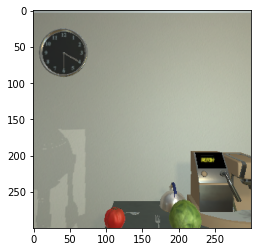

In [18]:
plt.imshow(env.last_event.frame)
plt.show()

In [19]:
 # set logger
log_level = logging.DEBUG if args.debug else logging.INFO
log_handlers = [logging.StreamHandler(), logging.FileHandler(args.log_dir)]
logging.basicConfig(handlers=log_handlers, level=log_level,
    format='%(asctime)s %(message)s', datefmt='%Y-%m-%d %H:%M:%S')

In [20]:
success_record = []

In [21]:
all_trial_paths = load_all_trial_paths("../ET/valid/set1_all/")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1418/1418 [00:00<00:00, 28335.30it/s]


In [22]:
len(all_trial_paths)

3535

In [23]:
all_trial_paths[0].split("/")[4].split('_')[-2].split('-')[-1]

'220'

In [ ]:
for idx in tqdm(range(len(all_trial_paths))):
    if idx < 1000 or idx >= 1500:
        continue
    try:
        #with timeout(100, exception=RuntimeError):
        with open(all_trial_paths[idx], 'r') as f:
            traj_raw = json.load(f)

        traj_data = traj_raw

        prtfunc = print #logging.debug
        prtfunc('-'*50)
        prtfunc(traj_data['task_desc'])

        traj_data['task_desc']

        scene_name = all_trial_paths[idx].split("/")[4].split('_')[-2].split('-')[-1]#all_trial_paths[0].split("/")[4].split("-")[-1].split("_")[0] #traj_data['task_desc'].split("/")[0].split('-')[-1]
        scene_name = "FloorPlan" + scene_name + "_physics"
        #scene_name = all_trial_paths[idx].split("/")[4].split("]")[1]
        print(scene_name)
        env.reset(scene_name)

        scene_name

        model_navi = model_mani = model

        setup_scene(traj_data, env)

#         plt.imshow(env.last_event.frame)
#         plt.show()

        traj_data['raw'] = traj_raw

        traj_raw['task_id'] = "??"

        try:
            horizon = traj_data['raw']['scene']['init_action']['horizon']
            rotation = traj_data['raw']['scene']['init_action']['rotation']
        except:
            horizon = rotation = 0

        all_done, success = False, False
        high_idx, high_fails, high_steps, api_fails = 0, 0, 0, 0
        high_history = ['[SOS]', 'None']
        high_history_before_last_navi = copy.deepcopy(high_history)
        low_history_col = []
        reward = 0
        t = 0
        stop_cond = ''
        failed_events= ''
        terminate = False

        path_name = traj_data['raw']['task_id'] + '_ridx' + str(0)
        visualize_info = {'save_path': os.path.join(args.log_dir.replace('.log', ''), path_name)}

        t_start_total = time.time()

        # while not all_done

        while not all_done:
            high_steps += 1
            # break if max_steps reached
            if high_fails >= args.max_high_fails:
                stop_cond += 'Terminate due to reach maximum high repetition failures'
                break

            if high_idx >= args.max_high_steps:
                stop_cond += 'Terminate due to reach maximum high steps'
                break

            # traj_data

            ex = traj_data

            # goal instruction
            task_desc = ex['turk_annotations']['anns'][0]['task_desc']

            # step-by-step instructions
            high_descs = ex['turk_annotations']['anns'][0]['high_descs']

            # tokenize language
            traj_data['lang'] = {
                'repeat_idx': 0,
                'goal_tokenize': ['[SEP]'] + revtok.tokenize(remove_spaces_and_lower(task_desc)) + ['[SEP]'],
                'instr_tokenize': [['[SEP]'] + revtok.tokenize(remove_spaces_and_lower(x)) + ['[SEP]'] for x in high_descs]
            }

            traj = traj_data

            traj['lang']['goal'] = vocab.seq_encode(traj['lang']['goal_tokenize'])
            traj['lang']['instr'] = [vocab.seq_encode(x) for x in traj['lang']['instr_tokenize']]

            with torch.no_grad():
                curr_frame = env.last_event.frame
                masks, boxes, classes, scores = detector.get_preds_step(curr_frame)
                # prtfunc('MaskRCNN Top8: ' + ''.join(['(%s, %.3f)'%(i, j) for i, j in zip(classes[:8], scores[:8])]))

                observations = {}
                observations['lang'] = traj_data['lang']['goal'] if not args.eval_disable_feat_lang_high else None
                observations['vis'] = [boxes, classes, scores] if not args.eval_disable_feat_vis else None
                observations['act_his'] = high_history if not args.eval_disable_feat_action_his else None
                observations['vis_his'] = None
                observations['pos'] = None

                # model predicts topk proposals
                preds, probs  = model_mani.step(observations, 'high', topk=5)
                high_actions, high_args = preds['type'], preds['arg']

            # Simply use the top1 high prediction instead of using multiple high proposals
            high_action = high_actions[0]
            high_arg = high_args[0]
            visualize_info['high_idx'] = high_idx
            visualize_info['high_action'] = high_action
            visualize_info['high_arg'] = high_arg

        #     prtfunc('-'*50)
        #     prtfunc('Task goal: ' + ''.join(traj_data['lang']['goal_tokenize']).replace('  ', ' '))
        #     prtfunc('High proposals:')
        #     prtfunc('action: ' + ''.join(['(%s, %.3f)'%(high_abbr[i], j) for i, j in zip(high_actions, probs['type'])]))
        #     prtfunc('arg: ' + ''.join(['(%s, %.3f)'%(i, j) for i, j in zip(high_args, probs['arg'])]))

            if high_action == 'GotoLocation':
                high_history_before_last_navi = copy.deepcopy(high_history)


            if high_action == 'NoOp':
                all_done = True
                stop_cond += 'Predictes a high-level NoOp to terminate!'
                break

            # print action
        #     prtfunc('high history' + str(high_history))
        #     prtfunc('high pred: %s(%s)'%(high_action, high_arg))
        #     prtfunc('high idx: %d'%high_idx)
        #     prtfunc('high fails: %d'%high_fails)

            # go into the low-level action prediction loop
            subgoal_done, prev_t_success = False, False
            low_idx = 0
            low_history = [high_action, high_arg]
            low_vis_history = []
            while not subgoal_done:
                # break if max_steps reached
                if low_idx >= args.max_low_steps:
                    failed_events += 'SG %s(%s) not done in %d steps |'%(high_action, high_arg, args.max_low_steps)
                    # prtfunc("Reach maximum low step limitation. Subgoal '%s(%s)' failed" %(high_action, high_arg))
                    break

        #         prtfunc('-'*50)
        #         prtfunc('Completing subgoal: %s(%s)'%(high_action, high_arg))

                if args.use_gt_navigation and high_action == 'GotoLocation':
                    try:
                        proposals = [(vocabs['out_vocab_low_type'].id2w(traj_data['low']['dec_out_low_actions'][high_idx][low_idx]), None, None)]
                        # prtfunc('Use ground truth navigation actions')
                    except:
                        stop_cond += 'Terminate due to do not find proper ground truth navigation actions! '
                        all_done = True
                        break

                else:
                    with torch.no_grad():
                        task_type = 'low_navi' if high_action == 'GotoLocation' else 'low_mani'
                        model = model_navi if task_type == 'low_navi' else model_mani
                        # visual observation
                        curr_frame = env.last_event.frame
                        masks, boxes, classes, scores = detector.get_preds_step(curr_frame)
                        # prtfunc('MaskRCNN Top8: ' + ''.join(['(%s, %.3f)'%(i, j) for i, j in zip(classes[:8], scores[:8])]))

                        # disable language directives when retry the navigation subgoal
                        global_disable = args.eval_disable_feat_lang_navi if 'navi' in task_type else args.eval_disable_feat_lang_mani
                        use_lang = not global_disable and high_idx == len(low_history_col) and high_idx<len(traj_data['lang']['instr'])
                        if use_lang:
                            pass
                            # prtfunc('Instruction: ' + ''.join(traj_data['lang']['instr_tokenize'][high_idx]).replace('  ', ' '))
                        use_vis_his = args.eval_enable_feat_vis_his and 'navi' in task_type
                        use_pos = args.eval_enable_feat_posture and 'navi' in task_type


                        observations = {}
                        observations['lang'] = traj_data['lang']['instr'][high_idx] if use_lang else None
                        observations['vis'] = [boxes, classes, scores] if not args.eval_disable_feat_vis else None
                        observations['act_his'] = low_history if not args.eval_disable_feat_action_his else None
                        observations['vis_his'] = low_vis_history if use_vis_his else None
                        observations['pos'] = {'rotation': int((rotation%360)/90),
                                                            'horizon': int(horizon/15)%12} if use_pos else None

                        # model predicts topk proposals
                        preds, probs = model.step(observations, task_type, topk=13)
                        low_actions, low_args, mask_ids = preds['type'], preds['arg'], preds['mask']

                        if task_type == 'low_navi':
                            # proposals = [(low_actions[i], None, None) for i in range(5) if probs['type'][i]]
                            proposals = [(low_actions[0], None, None)]
                            # Obstruction Detection technique from MOCA
                            if low_actions[0] == 'MoveAhead':
                                cands = ['RotateLeft', 'RotateRight', 'NoOp']
                                cand_rank= [low_actions.index(i) for i in cands]
                                probs['type'][cand_rank[2]] += 0.05 # encourage stopping
                                cand_probs = [probs['type'][i] for i in cand_rank]
                                cand_idx = cand_probs.index(max(cand_probs))
                                proposals.append((cands[cand_idx], None, None))
                            # prtfunc('Low proposal: '+ str([i for i,j,k in proposals]))
                        else:
                            # proposals = [(low_actions[0], low_args[i], mask_ids[i]) for i in range(3)]
                            proposals = []
                            for act_idx, act_prob in enumerate(probs['type']):
                                for arg_idx, arg_prob in enumerate(probs['type']):
                                    if act_prob > 0.1 and arg_prob > 0.1:
                                        proposals.append((low_actions[act_idx], low_args[arg_idx], mask_ids[arg_idx]))
                                        #prtfunc('Low proposal: %s(%.2f) %s(%.2f)'%(low_actions[act_idx], act_prob,low_args[arg_idx], arg_prob))

                # prtfunc('Low proposals:' + str(proposals))
                # prtfunc('action: ' + ''.join(['(%s, %.3f)'%(i, j) for i, j in zip(low_actions, probs['type'])]))
                # prtfunc('arg: ' + ''.join(['(%s, %.3f)'%(i, j) for i, j in zip(low_args, probs['arg'])]))
                # prtfunc('mask: ' + ''.join(['(%s, %.3f)'%(i, j) for i, j in zip(mask_ids, probs['mask'])]))

                t_success = False
                for action, low_arg, mask_id in proposals:
                    if action == 'NoOp' and (high_action=='GotoLocation' or prev_t_success):
                        low_history += [action, low_arg]
                        low_vis_history += [observations['vis']] if args.eval_enable_feat_vis_his else []
                        subgoal_done = True
                        # prtfunc("Subgoal '%s(%s)' is done! low steps: %d"%(high_action, high_arg, low_idx+1))
                        break

                    # disable masks/arguments for non-ineractive actions
                    if action in NON_INTERACT_ACTIONS:
                        low_arg = 'None'
                        mask = None
                    elif args.use_gt_mask:
                        mask = decompress_mask(traj_data['low']['mask'][high_idx][low_idx])
                    else:
                        try:
                            mask = masks[mask_id - 1]
                            mask_cls_pred = classes[mask_id-1]
                            if not similar(mask_cls_pred, low_arg):
                                failed_events += 'bad mask: %s -> %s |'%(mask_cls_pred, low_arg)
                                # prtfunc('Agent: no correct mask grounding!')
                                mask = None
                        except:
                            # if low_arg in classes:
                            #     mask = masks[classes.index(low_arg)]
                            if mask_id == 0:
                                failed_events += 'pred mask: 0 |'
                                #prtfunc('Agent: no available mask')
                                mask = None
                            else:
                                failed_events += 'Invaild mask id: %s |'%str(mask_id)
                                #prtfunc('Invaild mask id: %s'%str(mask_id))
                                mask = None

                    if args.save_video:
                        visualize_info['low_idx'] = low_idx
                        visualize_info['low_action'] = action
                        visualize_info['low_arg'] = low_arg
                        visualize_info['global_step'] = t
                        visualize_info['mask'] = mask
                        visualize_info['bbox'] = boxes[mask_id - 1] if mask is not None else None
                        visualize_info['class'] = mask_cls_pred  if mask is not None else None
                        visualize_info_ = visualize_info
                    else:
                        visualize_info_ = None

                    if action not in NON_INTERACT_ACTIONS and mask is None:
                        if args.save_video:
                            save_frame_failure(env.last_event.frame[:, :, ::-1], visualize_info_)
                        prev_t_success = False
                        continue

                    # use action and predicted mask (if available) to interact with the env
                    t_success, _, _, err, _ = env.va_interact(action, interact_mask=mask,
                        smooth_nav=args.smooth_nav, debug=args.debug, visualize_info=visualize_info_)
                    t += 1
                    prev_t_success = t_success

                    if t_success:
                        low_history += [action, low_arg]
                        low_vis_history += [observations['vis']] if args.eval_enable_feat_vis_his else []
                        rotation += 90 if action == 'RotateRight' else -90 if action == 'RotateLeft' else 0
                        horizon += 15 if action == 'LookUp' else -15 if action == 'LookDown' else 0
                        #prtfunc('low pred: %s(%s)'%(action, low_arg))
                        #prtfunc('Agent posture: rotation: %d horizon: %d'%(rotation, horizon))
                        #prtfunc('high idx: %d (fails: %s)  low idx: %d'%(high_idx, high_fails, low_idx))
                        #prtfunc('Successfully executed!')
                        #prtfunc('Low history: '+' '.join(['%s'%i for i in low_history[::2]]))
                        # t_reward, t_done = env.get_transition_reward()
                        # reward += t_reward
                        low_idx += 1
                        break
                    else:
                        api_fails += 1
                        if api_fails >= args.max_fails:
                            stop_cond = 'Reach 10 Api fails'
                            terminate = True
                        failed_events += 'bad action: %s(%s) api fail: %d |'%(action, low_arg, api_fails)
                        #prtfunc('Low pred: %s(%s)'%(action, low_arg))
                        #prtfunc('Low action failed! Try another low proposal')

                if terminate:
                    break

                if not prev_t_success:   # fails in all the proposals, get stuck
                    failed_events += 'SG %s(%s) fail(%d): no valid proposal |'%(high_action, high_arg, high_fails)
                    #prtfunc("Failed in all low proposals. Subgoal '%s(%s)' failed" %(high_action, high_arg))
                    break

            # out of the low loop and return to the high loop
            if terminate:
                break

            if subgoal_done:
                if high_idx == len(low_history_col):
                    # a new subgoal is completed
                    low_history_col.append(low_history)
                    # high_fails = 0
                else:
                    # a previously failed subgoal is completed
                    low_history_col[high_idx].extend(low_history[2:])
                high_history += [high_action, high_arg]
                high_idx += 1
            else:
                high_fails += 1
                if high_action == 'GotoLocation':
                    # if a navigation subgoal fails, simply retry it
                    high_history = high_history
                    high_idx = high_idx
                    failed_events += 'Navi failed (step: %d) |'%high_steps
                    #prtfunc("Navigation failed. Try again!")
                else:
                    # if a manipulative subgoal fails, retry the navigation subgoal before that
                    high_history = copy.deepcopy(high_history_before_last_navi)
                    high_idx = int(len(high_history)/2 - 1)
                    failed_events += 'SG %s(%s) failed: go back to hidx: %d |'%(high_action, high_arg, high_idx)
                    #prtfunc("Subgoal '%s(%s)' failed. Retry the navigation before that!" %(high_action, high_arg))


        task_nname =  traj_data['task_desc'].split("-")[0]
        s, ts = get_goal_conditions_meet(task_nname, traj_data['pddl_params'], env.last_event, env)
        success_record.append([traj_data['task_desc'], s, ts])

        print(task_nname, s, ts)
    except Exception as e:
        print("wrong task: ", all_trial_paths[idx], e)

  0%|                                                                                                                                      | 0/3535 [00:00<?, ?it/s]

--------------------------------------------------
pick_cool_then_place_in_recep-Pot-None-CounterTop-1/trial_T20190909_124252_504581
FloorPlan1_physics
Resetting ThorEnv


/home/ubuntu/anaconda3/envs/hitut/lib/python3.7/site-packages/torchvision/ops/boxes.py:101: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  keep = keep.nonzero().squeeze(1)
 28%|██████████████████████████████████▊                                                                                        | 1001/3535 [00:37<01:34, 26.68it/s]

pick_cool_then_place_in_recep 1 3
--------------------------------------------------
pick_cool_then_place_in_recep-Pot-None-CounterTop-1/trial_T20190909_124332_831471
FloorPlan1_physics
Resetting ThorEnv


 28%|██████████████████████████████████▊                                                                                        | 1002/3535 [01:19<04:07, 10.22it/s]

pick_cool_then_place_in_recep 1 3
--------------------------------------------------
pick_cool_then_place_in_recep-Pot-None-CounterTop-1/trial_T20190909_113238_759245
FloorPlan1_physics
Resetting ThorEnv


 28%|██████████████████████████████████▉                                                                                        | 1003/3535 [01:45<06:20,  6.65it/s]

pick_cool_then_place_in_recep 1 3
--------------------------------------------------
pick_two_obj_and_place-SoapBar-None-BathtubBasin-423/trial_T20190909_034242_176519
FloorPlan423_physics
Resetting ThorEnv


 28%|██████████████████████████████████▉                                                                                        | 1004/3535 [02:00<08:03,  5.23it/s]

pick_two_obj_and_place 0 2
--------------------------------------------------
pick_two_obj_and_place-SoapBar-None-BathtubBasin-423/trial_T20190909_034124_266294
FloorPlan423_physics
Resetting ThorEnv


 28%|██████████████████████████████████▉                                                                                        | 1005/3535 [02:38<14:36,  2.89it/s]

pick_two_obj_and_place 1 2
--------------------------------------------------
pick_two_obj_and_place-SoapBar-None-BathtubBasin-423/trial_T20190909_034155_743816
FloorPlan423_physics
Resetting ThorEnv


 28%|███████████████████████████████████                                                                                        | 1006/3535 [03:02<20:33,  2.05it/s]

pick_two_obj_and_place 1 2
--------------------------------------------------
look_at_obj_in_light-Bowl-None-DeskLamp-316/trial_T20190908_230635_560113
FloorPlan316_physics
Resetting ThorEnv


 28%|███████████████████████████████████                                                                                        | 1007/3535 [03:18<25:59,  1.62it/s]

look_at_obj_in_light 2 2
--------------------------------------------------
look_at_obj_in_light-Bowl-None-DeskLamp-316/trial_T20190908_230650_245482
FloorPlan316_physics
Resetting ThorEnv


 29%|███████████████████████████████████                                                                                        | 1008/3535 [03:35<34:01,  1.24it/s]

look_at_obj_in_light 0 2
--------------------------------------------------
pick_clean_then_place_in_recep-Cloth-None-BathtubBasin-407/trial_T20190908_054352_258440
FloorPlan407_physics
Resetting ThorEnv


 29%|███████████████████████████████████                                                                                        | 1009/3535 [03:51<44:30,  1.06s/it]

pick_clean_then_place_in_recep 3 3
--------------------------------------------------
pick_two_obj_and_place-Pen-None-Desk-312/trial_T20190907_212156_154708
FloorPlan312_physics
Resetting ThorEnv


 29%|███████████████████████████████████▏                                                                                       | 1010/3535 [03:56<48:45,  1.16s/it]

pick_two_obj_and_place 2 2
--------------------------------------------------
pick_clean_then_place_in_recep-Knife-None-SideTable-21/trial_T20190907_155305_725488
FloorPlan21_physics
Resetting ThorEnv


 29%|██████████████████████████████████▌                                                                                      | 1011/3535 [04:23<1:22:25,  1.96s/it]

pick_clean_then_place_in_recep 1 3
--------------------------------------------------
pick_clean_then_place_in_recep-Knife-None-SideTable-21/trial_T20190907_155410_611651
FloorPlan21_physics
Resetting ThorEnv


 29%|██████████████████████████████████▋                                                                                      | 1012/3535 [04:41<1:52:21,  2.67s/it]

pick_clean_then_place_in_recep 0 3
--------------------------------------------------
pick_clean_then_place_in_recep-Knife-None-SideTable-21/trial_T20190907_155338_488905
FloorPlan21_physics
Resetting ThorEnv


 29%|██████████████████████████████████▋                                                                                      | 1013/3535 [05:04<2:40:41,  3.82s/it]

pick_clean_then_place_in_recep 1 3
--------------------------------------------------
pick_and_place_simple-CellPhone-None-Bed-321/trial_T20190908_231504_321117
FloorPlan321_physics
Resetting ThorEnv


 29%|██████████████████████████████████▋                                                                                      | 1014/3535 [05:13<2:59:36,  4.27s/it]

pick_and_place_simple 1 1
--------------------------------------------------
pick_and_place_simple-CellPhone-None-Bed-321/trial_T20190908_231541_058766
FloorPlan321_physics
Resetting ThorEnv


 29%|██████████████████████████████████▋                                                                                      | 1015/3535 [05:20<3:08:29,  4.49s/it]

pick_and_place_simple 0 1
--------------------------------------------------
pick_cool_then_place_in_recep-Apple-None-Microwave-11/trial_T20190909_012231_659144
FloorPlan11_physics
Resetting ThorEnv


 29%|██████████████████████████████████▊                                                                                      | 1016/3535 [05:39<4:26:34,  6.35s/it]

pick_cool_then_place_in_recep 0 3
--------------------------------------------------
pick_cool_then_place_in_recep-Apple-None-Microwave-11/trial_T20190909_012317_645496
FloorPlan11_physics
Resetting ThorEnv


 29%|██████████████████████████████████▊                                                                                      | 1017/3535 [06:18<7:53:02, 11.27s/it]

pick_cool_then_place_in_recep 0 3
--------------------------------------------------
pick_cool_then_place_in_recep-Apple-None-Microwave-11/trial_T20190909_012201_694037
FloorPlan11_physics
Resetting ThorEnv


 29%|██████████████████████████████████▊                                                                                      | 1018/3535 [06:39<9:05:07, 12.99s/it]

pick_cool_then_place_in_recep 3 3
--------------------------------------------------
look_at_obj_in_light-Box-None-DeskLamp-303/trial_T20190909_110923_137845
FloorPlan303_physics
Resetting ThorEnv


 29%|██████████████████████████████████▉                                                                                      | 1019/3535 [06:46<8:12:32, 11.75s/it]

look_at_obj_in_light 1 2
--------------------------------------------------
look_at_obj_in_light-Box-None-DeskLamp-303/trial_T20190909_110910_527244
FloorPlan303_physics
Resetting ThorEnv


 29%|██████████████████████████████████▉                                                                                      | 1020/3535 [06:54<7:33:23, 10.82s/it]

look_at_obj_in_light 0 2
--------------------------------------------------
look_at_obj_in_light-Box-None-DeskLamp-303/trial_T20190909_110934_400678
FloorPlan303_physics
Resetting ThorEnv


 29%|██████████████████████████████████▉                                                                                      | 1021/3535 [07:12<8:52:26, 12.71s/it]

look_at_obj_in_light 1 2
--------------------------------------------------
pick_and_place_with_movable_recep-Knife-Mug-DiningTable-11/trial_T20190908_183041_574042
FloorPlan11_physics
Resetting ThorEnv


 29%|██████████████████████████████████▋                                                                                     | 1022/3535 [07:53<13:54:11, 19.92s/it]

pick_and_place_with_movable_recep 0 3
--------------------------------------------------
pick_and_place_with_movable_recep-Knife-Mug-DiningTable-11/trial_T20190913_151613_664892
FloorPlan11_physics
Resetting ThorEnv


 29%|██████████████████████████████████▋                                                                                     | 1023/3535 [08:33<17:32:46, 25.15s/it]

pick_and_place_with_movable_recep 0 3
--------------------------------------------------
pick_and_place_with_movable_recep-Knife-Mug-DiningTable-11/trial_T20190913_150941_022587
FloorPlan11_physics
Resetting ThorEnv


 29%|██████████████████████████████████▊                                                                                     | 1024/3535 [08:45<15:10:24, 21.75s/it]

pick_and_place_with_movable_recep 0 3
--------------------------------------------------
pick_and_place_with_movable_recep-Apple-Pan-DiningTable-18/trial_T20190908_062121_532423
FloorPlan18_physics
Resetting ThorEnv


 29%|██████████████████████████████████▊                                                                                     | 1025/3535 [09:17<17:09:14, 24.60s/it]

pick_and_place_with_movable_recep 0 3
--------------------------------------------------
pick_and_place_with_movable_recep-Apple-Pan-DiningTable-18/trial_T20190919_085326_820846
FloorPlan18_physics
Resetting ThorEnv


 29%|██████████████████████████████████▊                                                                                     | 1026/3535 [09:57<20:07:01, 28.86s/it]

pick_and_place_with_movable_recep 0 3
--------------------------------------------------
pick_and_place_with_movable_recep-Apple-Pan-DiningTable-18/trial_T20190908_055822_495768
FloorPlan18_physics
Resetting ThorEnv


 29%|██████████████████████████████████▊                                                                                     | 1027/3535 [11:04<27:55:02, 40.07s/it]

pick_and_place_with_movable_recep 0 3
--------------------------------------------------
pick_and_place_with_movable_recep-ButterKnife-Cup-CounterTop-27/trial_T20190908_233123_772326
FloorPlan27_physics
Resetting ThorEnv


 29%|██████████████████████████████████▉                                                                                     | 1028/3535 [11:20<22:54:56, 32.91s/it]

pick_and_place_with_movable_recep 0 3
--------------------------------------------------
pick_and_place_with_movable_recep-ButterKnife-Cup-CounterTop-27/trial_T20190908_233049_200893
FloorPlan27_physics
Resetting ThorEnv


 29%|██████████████████████████████████▉                                                                                     | 1029/3535 [11:42<20:45:35, 29.82s/it]

pick_and_place_with_movable_recep 0 3
--------------------------------------------------
pick_and_place_simple-RemoteControl-None-Sofa-207/trial_T20190909_153746_466577
FloorPlan207_physics
Resetting ThorEnv


 29%|██████████████████████████████████▉                                                                                     | 1030/3535 [11:51<16:26:58, 23.64s/it]

pick_and_place_simple 1 1
--------------------------------------------------
pick_and_place_simple-RemoteControl-None-Sofa-207/trial_T20190909_153653_822972
FloorPlan207_physics
Resetting ThorEnv


 29%|██████████████████████████████████▉                                                                                     | 1031/3535 [12:12<15:56:48, 22.93s/it]

pick_and_place_simple 0 1
--------------------------------------------------
pick_two_obj_and_place-TissueBox-None-DiningTable-230/trial_T20190909_145553_211575
FloorPlan230_physics
Resetting ThorEnv


 29%|███████████████████████████████████                                                                                     | 1032/3535 [12:51<19:08:01, 27.52s/it]

pick_two_obj_and_place 0 2
--------------------------------------------------
pick_two_obj_and_place-TissueBox-None-DiningTable-230/trial_T20190914_012602_275826
FloorPlan230_physics
Resetting ThorEnv


 29%|███████████████████████████████████                                                                                     | 1033/3535 [13:11<17:39:39, 25.41s/it]

pick_two_obj_and_place 0 2
--------------------------------------------------
pick_two_obj_and_place-TissueBox-None-DiningTable-230/trial_T20190909_145505_799057
FloorPlan230_physics
Resetting ThorEnv


 29%|███████████████████████████████████                                                                                     | 1034/3535 [13:19<14:02:05, 20.20s/it]

pick_two_obj_and_place 0 2
--------------------------------------------------
pick_heat_then_place_in_recep-Apple-None-SinkBasin-19/trial_T20190907_154313_788284
FloorPlan19_physics
Resetting ThorEnv


 29%|███████████████████████████████████▏                                                                                    | 1035/3535 [13:52<16:43:14, 24.08s/it]

pick_heat_then_place_in_recep 0 3
--------------------------------------------------
pick_heat_then_place_in_recep-Apple-None-SinkBasin-19/trial_T20190907_154416_708646
FloorPlan19_physics
Resetting ThorEnv


Traceback (most recent call last):
  File "/home/ubuntu/research3/HiTUT/env/thor_env.py", line 602, in va_interact
    event, api_action = self.to_thor_api_exec(action, target_instance_id, smooth_nav, visualize_info)
  File "/home/ubuntu/research3/HiTUT/env/thor_env.py", line 438, in to_thor_api_exec
    inventory_object_id = self.last_event.metadata['inventoryObjects'][0]['objectId']
IndexError: list index out of range


Error: IndexError('list index out of range')


 29%|███████████████████████████████████▏                                                                                    | 1036/3535 [14:23<18:05:50, 26.07s/it]

pick_heat_then_place_in_recep 0 3
--------------------------------------------------
pick_heat_then_place_in_recep-Apple-None-SinkBasin-19/trial_T20190907_154345_599636
FloorPlan19_physics
Resetting ThorEnv


Traceback (most recent call last):
  File "/home/ubuntu/research3/HiTUT/env/thor_env.py", line 602, in va_interact
    event, api_action = self.to_thor_api_exec(action, target_instance_id, smooth_nav, visualize_info)
  File "/home/ubuntu/research3/HiTUT/env/thor_env.py", line 438, in to_thor_api_exec
    inventory_object_id = self.last_event.metadata['inventoryObjects'][0]['objectId']
IndexError: list index out of range


Error: IndexError('list index out of range')


Traceback (most recent call last):
  File "/home/ubuntu/research3/HiTUT/env/thor_env.py", line 602, in va_interact
    event, api_action = self.to_thor_api_exec(action, target_instance_id, smooth_nav, visualize_info)
  File "/home/ubuntu/research3/HiTUT/env/thor_env.py", line 438, in to_thor_api_exec
    inventory_object_id = self.last_event.metadata['inventoryObjects'][0]['objectId']
IndexError: list index out of range


Error: IndexError('list index out of range')


Traceback (most recent call last):
  File "/home/ubuntu/research3/HiTUT/env/thor_env.py", line 602, in va_interact
    event, api_action = self.to_thor_api_exec(action, target_instance_id, smooth_nav, visualize_info)
  File "/home/ubuntu/research3/HiTUT/env/thor_env.py", line 438, in to_thor_api_exec
    inventory_object_id = self.last_event.metadata['inventoryObjects'][0]['objectId']
IndexError: list index out of range


Error: IndexError('list index out of range')


 29%|███████████████████████████████████▏                                                                                    | 1037/3535 [14:44<17:05:33, 24.63s/it]

pick_heat_then_place_in_recep 0 3
--------------------------------------------------
look_at_obj_in_light-KeyChain-None-FloorLamp-225/trial_T20190909_124956_238640
FloorPlan225_physics
Resetting ThorEnv


 29%|███████████████████████████████████▏                                                                                    | 1038/3535 [15:08<16:58:28, 24.47s/it]

look_at_obj_in_light 1 2
--------------------------------------------------
look_at_obj_in_light-KeyChain-None-FloorLamp-225/trial_T20190909_124940_917734
FloorPlan225_physics
Resetting ThorEnv


 29%|███████████████████████████████████▎                                                                                    | 1039/3535 [15:35<17:27:46, 25.19s/it]

look_at_obj_in_light 1 2
--------------------------------------------------
look_at_obj_in_light-Pillow-None-DeskLamp-305/trial_T20190909_110653_100811
FloorPlan305_physics
Resetting ThorEnv


 29%|███████████████████████████████████▎                                                                                    | 1040/3535 [15:45<14:18:49, 20.65s/it]

look_at_obj_in_light 2 2
--------------------------------------------------
look_at_obj_in_light-Pillow-None-DeskLamp-324/trial_T20190908_155642_533831
FloorPlan324_physics
Resetting ThorEnv


 29%|███████████████████████████████████▎                                                                                    | 1041/3535 [15:51<11:14:38, 16.23s/it]

look_at_obj_in_light 2 2
--------------------------------------------------
look_at_obj_in_light-Pillow-None-DeskLamp-324/trial_T20190908_155703_086493
FloorPlan324_physics
Resetting ThorEnv


 29%|███████████████████████████████████▎                                                                                    | 1042/3535 [16:11<11:56:07, 17.24s/it]

look_at_obj_in_light 0 2
--------------------------------------------------
look_at_obj_in_light-Pillow-None-DeskLamp-324/trial_T20190908_155728_431043
FloorPlan324_physics
Resetting ThorEnv


 30%|███████████████████████████████████▍                                                                                    | 1043/3535 [16:29<12:12:20, 17.63s/it]

look_at_obj_in_light 0 2
--------------------------------------------------
pick_and_place_with_movable_recep-Fork-Bowl-CounterTop-17/trial_T20190907_113702_483525
FloorPlan17_physics
Resetting ThorEnv


 30%|███████████████████████████████████▍                                                                                    | 1044/3535 [17:00<14:50:45, 21.46s/it]

pick_and_place_with_movable_recep 0 3
--------------------------------------------------
pick_and_place_with_movable_recep-Fork-Bowl-CounterTop-17/trial_T20190907_113936_943496
FloorPlan17_physics
Resetting ThorEnv


 30%|███████████████████████████████████▍                                                                                    | 1045/3535 [17:30<16:42:52, 24.17s/it]

pick_and_place_with_movable_recep 3 3
--------------------------------------------------
pick_and_place_with_movable_recep-Fork-Bowl-CounterTop-17/trial_T20190907_113809_409531
FloorPlan17_physics
Resetting ThorEnv


 30%|███████████████████████████████████▌                                                                                    | 1046/3535 [17:54<16:37:36, 24.05s/it]

pick_and_place_with_movable_recep 1 3
--------------------------------------------------
pick_two_obj_and_place-CreditCard-None-Sofa-216/trial_T20190909_150017_974673
FloorPlan216_physics
Resetting ThorEnv


 30%|███████████████████████████████████▌                                                                                    | 1047/3535 [18:11<15:12:57, 22.02s/it]

pick_two_obj_and_place 0 2
--------------------------------------------------
pick_two_obj_and_place-CreditCard-None-Sofa-216/trial_T20190909_145949_254918
FloorPlan216_physics
Resetting ThorEnv


 30%|███████████████████████████████████▌                                                                                    | 1048/3535 [18:29<14:22:54, 20.82s/it]

pick_two_obj_and_place 0 2
--------------------------------------------------
pick_two_obj_and_place-CreditCard-None-Sofa-207/trial_T20190909_090035_107554
FloorPlan207_physics
Resetting ThorEnv


 30%|███████████████████████████████████▌                                                                                    | 1049/3535 [18:57<15:48:07, 22.88s/it]

pick_two_obj_and_place 0 2
--------------------------------------------------
pick_two_obj_and_place-CreditCard-None-Sofa-207/trial_T20190909_090114_325926
FloorPlan207_physics
Resetting ThorEnv


 30%|███████████████████████████████████▋                                                                                    | 1050/3535 [19:13<14:20:06, 20.77s/it]

pick_two_obj_and_place 0 2
--------------------------------------------------
pick_two_obj_and_place-CreditCard-None-Sofa-207/trial_T20190909_085924_009925
FloorPlan207_physics
Resetting ThorEnv


 30%|███████████████████████████████████▋                                                                                    | 1051/3535 [19:29<13:23:24, 19.41s/it]

pick_two_obj_and_place 2 2
--------------------------------------------------
pick_and_place_with_movable_recep-Fork-Mug-SinkBasin-11/trial_T20190907_002229_910284
FloorPlan11_physics
Resetting ThorEnv


 30%|███████████████████████████████████▋                                                                                    | 1052/3535 [20:07<17:08:07, 24.84s/it]

pick_and_place_with_movable_recep 0 3
--------------------------------------------------
pick_and_place_with_movable_recep-Fork-Mug-SinkBasin-11/trial_T20190907_002244_588707
FloorPlan11_physics
Resetting ThorEnv


 30%|███████████████████████████████████▋                                                                                    | 1053/3535 [20:39<18:42:42, 27.14s/it]

pick_and_place_with_movable_recep 0 3
--------------------------------------------------
pick_and_place_with_movable_recep-Fork-Mug-SinkBasin-11/trial_T20190907_002209_695125
FloorPlan11_physics
Resetting ThorEnv


 30%|███████████████████████████████████▊                                                                                    | 1054/3535 [21:20<21:31:03, 31.22s/it]

pick_and_place_with_movable_recep 0 3
--------------------------------------------------
look_at_obj_in_light-AlarmClock-None-DeskLamp-302/trial_T20190908_192808_880740
FloorPlan302_physics
Resetting ThorEnv


 30%|███████████████████████████████████▊                                                                                    | 1055/3535 [21:40<19:09:20, 27.81s/it]

look_at_obj_in_light 0 2
--------------------------------------------------
look_at_obj_in_light-AlarmClock-None-DeskLamp-302/trial_T20190908_192820_480968
FloorPlan302_physics
Resetting ThorEnv


 30%|███████████████████████████████████▊                                                                                    | 1056/3535 [21:59<17:22:14, 25.23s/it]

look_at_obj_in_light 0 2
--------------------------------------------------
look_at_obj_in_light-Pillow-None-DeskLamp-302/trial_T20190909_150941_601258
FloorPlan302_physics
Resetting ThorEnv


 30%|███████████████████████████████████▉                                                                                    | 1057/3535 [22:06<13:42:17, 19.91s/it]

look_at_obj_in_light 0 2
--------------------------------------------------
look_at_obj_in_light-Pillow-None-DeskLamp-302/trial_T20190909_150929_316139
FloorPlan302_physics
Resetting ThorEnv


 30%|███████████████████████████████████▉                                                                                    | 1058/3535 [22:24<13:15:47, 19.28s/it]

look_at_obj_in_light 1 2
--------------------------------------------------
look_at_obj_in_light-CreditCard-None-DeskLamp-314/trial_T20190906_201607_020913
FloorPlan314_physics
Resetting ThorEnv


 30%|███████████████████████████████████▉                                                                                    | 1059/3535 [22:47<13:57:53, 20.30s/it]

look_at_obj_in_light 0 2
--------------------------------------------------
look_at_obj_in_light-CreditCard-None-DeskLamp-314/trial_T20190906_201558_324636
FloorPlan314_physics
Resetting ThorEnv


 30%|███████████████████████████████████▉                                                                                    | 1060/3535 [23:19<16:26:28, 23.91s/it]

look_at_obj_in_light 1 2
--------------------------------------------------
look_at_obj_in_light-CreditCard-None-DeskLamp-314/trial_T20190906_201548_667159
FloorPlan314_physics
Resetting ThorEnv


 30%|████████████████████████████████████                                                                                    | 1061/3535 [23:27<13:01:23, 18.95s/it]

look_at_obj_in_light 2 2
--------------------------------------------------
pick_and_place_with_movable_recep-Pencil-Bowl-Dresser-330/trial_T20190907_163716_768151
FloorPlan330_physics
Resetting ThorEnv


 30%|████████████████████████████████████                                                                                    | 1062/3535 [23:42<12:22:47, 18.02s/it]

pick_and_place_with_movable_recep 0 3
--------------------------------------------------
pick_two_obj_and_place-Statue-None-SideTable-214/trial_T20190909_065508_033151
FloorPlan214_physics
Resetting ThorEnv


 30%|████████████████████████████████████                                                                                    | 1063/3535 [24:18<16:04:28, 23.41s/it]

pick_two_obj_and_place 0 2
--------------------------------------------------
pick_and_place_simple-Candle-None-SideTable-420/trial_T20190907_025655_142954
FloorPlan420_physics
Resetting ThorEnv


 30%|████████████████████████████████████                                                                                    | 1064/3535 [24:23<12:08:19, 17.69s/it]

pick_and_place_simple 1 1
--------------------------------------------------
pick_and_place_simple-Candle-None-SideTable-420/trial_T20190907_025635_534669
FloorPlan420_physics
Resetting ThorEnv


 30%|████████████████████████████████████▍                                                                                    | 1065/3535 [24:29<9:41:01, 14.11s/it]

pick_and_place_simple 1 1
--------------------------------------------------
pick_and_place_simple-Candle-None-SideTable-420/trial_T20190907_025706_872961
FloorPlan420_physics
Resetting ThorEnv


 30%|████████████████████████████████████▍                                                                                    | 1066/3535 [24:33<7:40:46, 11.20s/it]

pick_and_place_simple 1 1
--------------------------------------------------
pick_and_place_simple-SaltShaker-None-DiningTable-26/trial_T20190907_113736_672101
FloorPlan26_physics
Resetting ThorEnv


 30%|████████████████████████████████████▌                                                                                    | 1067/3535 [24:55<9:58:45, 14.56s/it]

pick_and_place_simple 1 1
--------------------------------------------------
pick_and_place_simple-SaltShaker-None-DiningTable-26/trial_T20190907_113833_592985
FloorPlan26_physics
Resetting ThorEnv


 30%|████████████████████████████████████▎                                                                                   | 1068/3535 [25:21<12:14:17, 17.86s/it]

pick_and_place_simple 1 1
--------------------------------------------------
pick_cool_then_place_in_recep-Pan-None-DiningTable-7/trial_T20190909_094708_361033
FloorPlan7_physics
Resetting ThorEnv


 30%|████████████████████████████████████▎                                                                                   | 1069/3535 [25:52<15:00:36, 21.91s/it]

pick_cool_then_place_in_recep 0 3
--------------------------------------------------
pick_cool_then_place_in_recep-Pan-None-DiningTable-7/trial_T20190908_233004_004856
FloorPlan7_physics
Resetting ThorEnv


Traceback (most recent call last):
  File "/home/ubuntu/research3/HiTUT/env/thor_env.py", line 602, in va_interact
    event, api_action = self.to_thor_api_exec(action, target_instance_id, smooth_nav, visualize_info)
  File "/home/ubuntu/research3/HiTUT/env/thor_env.py", line 438, in to_thor_api_exec
    inventory_object_id = self.last_event.metadata['inventoryObjects'][0]['objectId']
IndexError: list index out of range


Error: IndexError('list index out of range')


Traceback (most recent call last):
  File "/home/ubuntu/research3/HiTUT/env/thor_env.py", line 602, in va_interact
    event, api_action = self.to_thor_api_exec(action, target_instance_id, smooth_nav, visualize_info)
  File "/home/ubuntu/research3/HiTUT/env/thor_env.py", line 438, in to_thor_api_exec
    inventory_object_id = self.last_event.metadata['inventoryObjects'][0]['objectId']
IndexError: list index out of range
 30%|████████████████████████████████████▎                                                                                   | 1070/3535 [26:23<16:51:13, 24.61s/it]

Error: IndexError('list index out of range')
pick_cool_then_place_in_recep 0 3
--------------------------------------------------
pick_heat_then_place_in_recep-Cup-None-Fridge-13/trial_T20190908_070533_944479
FloorPlan13_physics
Resetting ThorEnv


 30%|████████████████████████████████████▎                                                                                   | 1071/3535 [26:56<18:26:24, 26.94s/it]

pick_heat_then_place_in_recep 0 3
--------------------------------------------------
pick_heat_then_place_in_recep-Cup-None-Fridge-13/trial_T20190908_070444_960595
FloorPlan13_physics
Resetting ThorEnv


 30%|████████████████████████████████████▍                                                                                   | 1072/3535 [27:39<21:46:15, 31.82s/it]

pick_heat_then_place_in_recep 0 3
--------------------------------------------------
pick_heat_then_place_in_recep-Cup-None-Fridge-13/trial_T20190908_070322_791516
FloorPlan13_physics
Resetting ThorEnv


 30%|████████████████████████████████████▍                                                                                   | 1073/3535 [28:10<21:33:06, 31.51s/it]

pick_heat_then_place_in_recep 0 3
--------------------------------------------------
look_at_obj_in_light-CreditCard-None-FloorLamp-225/trial_T20190909_110049_018526
FloorPlan225_physics
Resetting ThorEnv


 30%|████████████████████████████████████▍                                                                                   | 1074/3535 [28:50<23:25:13, 34.26s/it]

look_at_obj_in_light 0 2
--------------------------------------------------
look_at_obj_in_light-CreditCard-None-FloorLamp-225/trial_T20190909_103849_934231
FloorPlan225_physics
Resetting ThorEnv


 30%|████████████████████████████████████▍                                                                                   | 1075/3535 [29:07<19:50:45, 29.04s/it]

look_at_obj_in_light 1 2
--------------------------------------------------
pick_and_place_simple-Statue-None-CoffeeTable-230/trial_T20190909_145156_045732
FloorPlan230_physics
Resetting ThorEnv


 30%|████████████████████████████████████▌                                                                                   | 1076/3535 [29:33<19:11:29, 28.10s/it]

pick_and_place_simple 0 1
--------------------------------------------------
pick_and_place_simple-Statue-None-CoffeeTable-230/trial_T20190909_145138_877153
FloorPlan230_physics
Resetting ThorEnv


 30%|████████████████████████████████████▌                                                                                   | 1077/3535 [29:58<18:30:05, 27.10s/it]

pick_and_place_simple 0 1
--------------------------------------------------
pick_cool_then_place_in_recep-Mug-None-CoffeeMachine-5/trial_T20190908_170305_166722
FloorPlan5_physics
Resetting ThorEnv


 30%|████████████████████████████████████▌                                                                                   | 1078/3535 [30:23<18:01:29, 26.41s/it]

pick_cool_then_place_in_recep 0 3
--------------------------------------------------
pick_cool_then_place_in_recep-Pan-None-DiningTable-23/trial_T20190909_005731_236253
FloorPlan23_physics
Resetting ThorEnv


 31%|████████████████████████████████████▋                                                                                   | 1079/3535 [30:57<19:42:34, 28.89s/it]

pick_cool_then_place_in_recep 0 3
--------------------------------------------------
pick_cool_then_place_in_recep-Pan-None-DiningTable-23/trial_T20190909_005833_061416
FloorPlan23_physics
Resetting ThorEnv


 31%|████████████████████████████████████▋                                                                                   | 1080/3535 [31:26<19:39:48, 28.83s/it]

pick_cool_then_place_in_recep 1 3
--------------------------------------------------
pick_cool_then_place_in_recep-Pan-None-DiningTable-23/trial_T20190909_005801_641557
FloorPlan23_physics
Resetting ThorEnv


 31%|████████████████████████████████████▋                                                                                   | 1081/3535 [31:55<19:45:49, 28.99s/it]

pick_cool_then_place_in_recep 0 3
--------------------------------------------------
pick_two_obj_and_place-Pencil-None-CoffeeTable-229/trial_T20190908_122920_453209
FloorPlan229_physics
Resetting ThorEnv


 31%|████████████████████████████████████▋                                                                                   | 1082/3535 [32:33<21:34:22, 31.66s/it]

pick_two_obj_and_place 1 2
--------------------------------------------------
pick_two_obj_and_place-Pencil-None-CoffeeTable-229/trial_T20190910_231706_006365
FloorPlan229_physics
Resetting ThorEnv


 31%|████████████████████████████████████▊                                                                                   | 1083/3535 [34:07<34:18:41, 50.38s/it]

pick_two_obj_and_place 0 2
--------------------------------------------------
pick_two_obj_and_place-Pencil-None-CoffeeTable-229/trial_T20190910_224430_843186
FloorPlan229_physics
Resetting ThorEnv


 31%|████████████████████████████████████▊                                                                                   | 1084/3535 [34:45<31:39:42, 46.50s/it]

pick_two_obj_and_place 1 2
--------------------------------------------------
pick_clean_then_place_in_recep-Pot-None-StoveBurner-1/trial_T20190908_134303_573708
FloorPlan1_physics
Resetting ThorEnv


 31%|████████████████████████████████████▊                                                                                   | 1085/3535 [35:10<27:20:18, 40.17s/it]

pick_clean_then_place_in_recep 1 3
--------------------------------------------------
pick_clean_then_place_in_recep-Pot-None-StoveBurner-1/trial_T20190908_134336_754601
FloorPlan1_physics
Resetting ThorEnv


 31%|████████████████████████████████████▊                                                                                   | 1086/3535 [35:16<20:15:20, 29.78s/it]

pick_clean_then_place_in_recep 1 3
--------------------------------------------------
pick_clean_then_place_in_recep-Pot-None-StoveBurner-1/trial_T20190908_162746_478443
FloorPlan1_physics
Resetting ThorEnv


 31%|████████████████████████████████████▉                                                                                   | 1087/3535 [35:19<14:46:57, 21.74s/it]

pick_clean_then_place_in_recep 1 3
--------------------------------------------------
pick_cool_then_place_in_recep-Mug-None-SinkBasin-6/trial_T20190907_125559_972660
FloorPlan6_physics
Resetting ThorEnv


 31%|████████████████████████████████████▉                                                                                   | 1088/3535 [35:32<13:06:37, 19.29s/it]

pick_cool_then_place_in_recep 0 3
--------------------------------------------------
pick_cool_then_place_in_recep-Mug-None-SinkBasin-6/trial_T20190907_125524_243243
FloorPlan6_physics
Resetting ThorEnv


 31%|████████████████████████████████████▉                                                                                   | 1089/3535 [35:47<12:13:25, 17.99s/it]

pick_cool_then_place_in_recep 0 3
--------------------------------------------------
pick_cool_then_place_in_recep-Mug-None-SinkBasin-6/trial_T20190907_125626_653937
FloorPlan6_physics
Resetting ThorEnv


 31%|█████████████████████████████████████                                                                                   | 1090/3535 [36:15<14:08:57, 20.83s/it]

pick_cool_then_place_in_recep 0 3
--------------------------------------------------
pick_cool_then_place_in_recep-Plate-None-SinkBasin-19/trial_T20190909_111555_066704
FloorPlan19_physics
Resetting ThorEnv


 31%|█████████████████████████████████████                                                                                   | 1091/3535 [36:29<12:54:42, 19.02s/it]

pick_cool_then_place_in_recep 1 3
--------------------------------------------------
pick_cool_then_place_in_recep-Plate-None-SinkBasin-19/trial_T20190909_111630_769310
FloorPlan19_physics
Resetting ThorEnv


 31%|█████████████████████████████████████                                                                                   | 1092/3535 [36:50<13:13:59, 19.50s/it]

pick_cool_then_place_in_recep 0 3
--------------------------------------------------
pick_cool_then_place_in_recep-Plate-None-SinkBasin-19/trial_T20190909_111802_274490
FloorPlan19_physics
Resetting ThorEnv


 31%|█████████████████████████████████████                                                                                   | 1093/3535 [37:03<11:51:27, 17.48s/it]

pick_cool_then_place_in_recep 0 3
--------------------------------------------------
look_at_obj_in_light-Laptop-None-DeskLamp-216/trial_T20190907_185541_681881
FloorPlan216_physics
Resetting ThorEnv


 31%|█████████████████████████████████████▏                                                                                  | 1094/3535 [37:29<13:40:03, 20.16s/it]

look_at_obj_in_light 0 2
--------------------------------------------------
look_at_obj_in_light-Laptop-None-DeskLamp-216/trial_T20190907_185556_000181
FloorPlan216_physics
Resetting ThorEnv


 31%|█████████████████████████████████████▏                                                                                  | 1095/3535 [37:43<12:20:03, 18.20s/it]

look_at_obj_in_light 0 2
--------------------------------------------------
look_at_obj_in_light-Laptop-None-DeskLamp-216/trial_T20190907_185526_145194
FloorPlan216_physics
Resetting ThorEnv


 31%|█████████████████████████████████████▏                                                                                  | 1096/3535 [37:55<11:03:19, 16.32s/it]

look_at_obj_in_light 0 2
--------------------------------------------------
pick_two_obj_and_place-Lettuce-None-Fridge-1/trial_T20190908_124634_452782
FloorPlan1_physics
Resetting ThorEnv


 31%|█████████████████████████████████████▏                                                                                  | 1097/3535 [38:16<12:04:42, 17.84s/it]

pick_two_obj_and_place 0 2
--------------------------------------------------
pick_two_obj_and_place-Lettuce-None-Fridge-1/trial_T20190918_213438_348886
FloorPlan1_physics
Resetting ThorEnv


 31%|█████████████████████████████████████▎                                                                                  | 1098/3535 [38:55<16:15:05, 24.01s/it]

pick_two_obj_and_place 0 2
--------------------------------------------------
pick_two_obj_and_place-Lettuce-None-Fridge-1/trial_T20190918_212722_569040
FloorPlan1_physics
Resetting ThorEnv


 31%|█████████████████████████████████████▎                                                                                  | 1099/3535 [39:12<14:53:13, 22.00s/it]

pick_two_obj_and_place 0 2
--------------------------------------------------
pick_heat_then_place_in_recep-Tomato-None-DiningTable-17/trial_T20190909_042716_008360
FloorPlan17_physics
Resetting ThorEnv


 31%|█████████████████████████████████████▎                                                                                  | 1100/3535 [39:25<12:59:28, 19.21s/it]

pick_heat_then_place_in_recep 0 3
--------------------------------------------------
pick_heat_then_place_in_recep-Tomato-None-DiningTable-17/trial_T20190909_042816_697362
FloorPlan17_physics
Resetting ThorEnv


 31%|█████████████████████████████████████▎                                                                                  | 1101/3535 [39:57<15:41:22, 23.21s/it]

pick_heat_then_place_in_recep 1 3
--------------------------------------------------
pick_heat_then_place_in_recep-Tomato-None-DiningTable-17/trial_T20190909_042742_043093
FloorPlan17_physics
Resetting ThorEnv


 31%|█████████████████████████████████████▍                                                                                  | 1102/3535 [40:10<13:39:34, 20.21s/it]

pick_heat_then_place_in_recep 0 3
--------------------------------------------------
pick_cool_then_place_in_recep-Lettuce-None-GarbageCan-20/trial_T20190907_204440_642169
FloorPlan20_physics
Resetting ThorEnv


 31%|█████████████████████████████████████▍                                                                                  | 1103/3535 [40:30<13:29:25, 19.97s/it]

pick_cool_then_place_in_recep 0 3
--------------------------------------------------
pick_cool_then_place_in_recep-Lettuce-None-GarbageCan-20/trial_T20190907_204527_530630
FloorPlan20_physics
Resetting ThorEnv


 31%|█████████████████████████████████████▍                                                                                  | 1104/3535 [41:19<19:20:32, 28.64s/it]

pick_cool_then_place_in_recep 1 3
--------------------------------------------------
pick_cool_then_place_in_recep-Lettuce-None-GarbageCan-20/trial_T20190907_204404_064165
FloorPlan20_physics
Resetting ThorEnv


 31%|█████████████████████████████████████▌                                                                                  | 1105/3535 [42:04<22:45:42, 33.72s/it]

pick_cool_then_place_in_recep 1 3
--------------------------------------------------
pick_clean_then_place_in_recep-Mug-None-CoffeeMachine-25/trial_T20190907_223942_379753
FloorPlan25_physics
Resetting ThorEnv


 31%|█████████████████████████████████████▌                                                                                  | 1106/3535 [42:25<20:08:11, 29.84s/it]

pick_clean_then_place_in_recep 1 3
--------------------------------------------------
pick_clean_then_place_in_recep-Mug-None-CoffeeMachine-25/trial_T20190907_224012_058575
FloorPlan25_physics
Resetting ThorEnv


 31%|█████████████████████████████████████▌                                                                                  | 1107/3535 [42:55<20:13:07, 29.98s/it]

pick_clean_then_place_in_recep 0 3
--------------------------------------------------
pick_clean_then_place_in_recep-Mug-None-CoffeeMachine-25/trial_T20190907_224032_931193
FloorPlan25_physics
Resetting ThorEnv


 31%|█████████████████████████████████████▌                                                                                  | 1108/3535 [43:06<16:24:07, 24.33s/it]

pick_clean_then_place_in_recep 3 3
--------------------------------------------------
pick_heat_then_place_in_recep-Mug-None-CoffeeMachine-23/trial_T20190906_194121_936472
FloorPlan23_physics
Resetting ThorEnv


 31%|█████████████████████████████████████▋                                                                                  | 1109/3535 [43:23<14:55:05, 22.14s/it]

pick_heat_then_place_in_recep 0 3
--------------------------------------------------
pick_heat_then_place_in_recep-Mug-None-CoffeeMachine-23/trial_T20190906_194049_566589
FloorPlan23_physics
Resetting ThorEnv


 31%|█████████████████████████████████████▋                                                                                  | 1110/3535 [43:46<14:59:46, 22.26s/it]

pick_heat_then_place_in_recep 0 3
--------------------------------------------------
pick_heat_then_place_in_recep-Mug-None-CoffeeMachine-23/trial_T20190906_194152_150964
FloorPlan23_physics
Resetting ThorEnv


 31%|█████████████████████████████████████▋                                                                                  | 1111/3535 [43:57<12:38:50, 18.78s/it]

pick_heat_then_place_in_recep 0 3
--------------------------------------------------
pick_cool_then_place_in_recep-Potato-None-GarbageCan-17/trial_T20190908_204236_762891
FloorPlan17_physics
Resetting ThorEnv


 31%|█████████████████████████████████████▋                                                                                  | 1112/3535 [44:25<14:30:05, 21.55s/it]

pick_cool_then_place_in_recep 0 3
--------------------------------------------------
pick_cool_then_place_in_recep-Potato-None-GarbageCan-17/trial_T20190908_204111_799665
FloorPlan17_physics
Resetting ThorEnv


 31%|█████████████████████████████████████▊                                                                                  | 1113/3535 [44:56<16:34:16, 24.63s/it]

pick_cool_then_place_in_recep 0 3
--------------------------------------------------
pick_cool_then_place_in_recep-Potato-None-GarbageCan-17/trial_T20190908_204151_818156
FloorPlan17_physics
Resetting ThorEnv


Traceback (most recent call last):
  File "/home/ubuntu/research3/HiTUT/env/thor_env.py", line 602, in va_interact
    event, api_action = self.to_thor_api_exec(action, target_instance_id, smooth_nav, visualize_info)
  File "/home/ubuntu/research3/HiTUT/env/thor_env.py", line 438, in to_thor_api_exec
    inventory_object_id = self.last_event.metadata['inventoryObjects'][0]['objectId']
IndexError: list index out of range


Error: IndexError('list index out of range')


 32%|█████████████████████████████████████▊                                                                                  | 1114/3535 [45:20<16:25:58, 24.44s/it]

pick_cool_then_place_in_recep 0 3
--------------------------------------------------
pick_and_place_with_movable_recep-RemoteControl-Box-Sofa-222/trial_T20190907_210439_150864
FloorPlan222_physics
Resetting ThorEnv


 32%|█████████████████████████████████████▊                                                                                  | 1115/3535 [45:47<16:47:47, 24.99s/it]

pick_and_place_with_movable_recep 1 3
--------------------------------------------------
pick_and_place_with_movable_recep-RemoteControl-Box-Sofa-222/trial_T20190907_210609_769764
FloorPlan222_physics
Resetting ThorEnv


 32%|█████████████████████████████████████▉                                                                                  | 1116/3535 [46:20<18:26:09, 27.44s/it]

pick_and_place_with_movable_recep 1 3
--------------------------------------------------
pick_and_place_with_movable_recep-RemoteControl-Box-Sofa-222/trial_T20190907_210401_075111
FloorPlan222_physics
Resetting ThorEnv


 32%|█████████████████████████████████████▉                                                                                  | 1117/3535 [46:54<19:47:16, 29.46s/it]

pick_and_place_with_movable_recep 1 3
--------------------------------------------------
look_at_obj_in_light-BasketBall-None-DeskLamp-305/trial_T20190907_151920_641687
FloorPlan305_physics
Resetting ThorEnv


 32%|█████████████████████████████████████▉                                                                                  | 1118/3535 [47:10<17:09:16, 25.55s/it]

look_at_obj_in_light 1 2
--------------------------------------------------
look_at_obj_in_light-BasketBall-None-DeskLamp-305/trial_T20190907_151907_928628
FloorPlan305_physics
Resetting ThorEnv


 32%|█████████████████████████████████████▉                                                                                  | 1119/3535 [47:19<13:40:44, 20.38s/it]

look_at_obj_in_light 1 2
--------------------------------------------------
look_at_obj_in_light-BasketBall-None-DeskLamp-305/trial_T20190907_151853_772114
FloorPlan305_physics
Resetting ThorEnv


In [ ]:
with open("hitut_1000_1500.txt", "w") as f:
    for r in success_record:
        f.write(r[0] + " " + str(r[1]) + " " + str(r[2]) + "\n")